In [1]:
### Import Statements
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge as cpu_Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from tqdm.auto import tqdm, trange
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
import joblib
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from scipy.stats import uniform, expon, norm, randint
import matplotlib.pyplot as plt
import time 
import warnings
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
import time
from helpful_functions import *

### Loading SVGP

In [2]:
num_inputs = 4
num_outputs = 3 # Must have 4:3 function for this optimization to work
noise_level = 10 # Train on 10% noise
datype = np.float32

model_path = "SVGP 2024-07-19-16-35-26.pth"
likelihood_path = "Likelihood 2024-07-19-16-35-26.pth"
input_scaler_path = "Input Transformer 2024-07-19-16-35-26.sav"
output_scaler_path = "Output Transformer 2024-07-19-16-35-26.sav"

In [3]:
# Initializing NN and Loading trained parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 2**14
model = GPRegressor(
    MultitaskSVGPModel,
    module__num_tasks=3,
    module__num_latents=8,
    module__inducing_points = torch.rand(2000, 4),
    
    criterion = gpytorch.mlls.VariationalELBO,
    criterion__num_data = 100,
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3),
    
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)
model.initialize()
model.module_.load_state_dict(torch.load(model_path, map_location=device))
model.likelihood_.load_state_dict(torch.load(likelihood_path, map_location=device))

<All keys matched successfully>

In [5]:
# Load input/output transformers
input_transformer = joblib.load(input_scaler_path)
output_transformer = joblib.load(output_scaler_path)

In [8]:
input_list = ['Intensity', 'Target Thickness', 'Focal Distance', 'Contrast'] # independent variables
output_list = ['Max Proton Energy', 'Total Proton Energy', 'Avg Proton Energy']
identifier = 'threeEns'

# Easiest to load in this specific dataframe for visualizing dip
train_df1 = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_campaign1_pct_100_noise_{noise_level}.h5', key='df')#.sample(n=20000,random_state=1)
#train_df2 = pd.read_hdf(f'datasets/fuchs_v4-2_seed-2_train_1274091_noise_{noise_level}_{identifier}_campaign2.h5', key='df')
# train_df = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_1525000_noise_{noise_level}_{identifier}_.h5', key='df').fillna(0).sample(frac=1,random_state=42).reset_index(drop=True)
# train_df.loc[:, output_list] = train_df.loc[:, output_list].replace(0, 1e-2)
test_df = pd.read_hdf('datasets/fuchs_v5_0_seed-2_test_250000_noise_0_threeEns_.h5', key = 'df').fillna(0)
test_df.loc[:, output_list] = test_df.loc[:, output_list].clip(1e-2, None)
# datype = np.float32

# # Define X, y as arrays
# X = np.array(train_df[input_list],dtype=datype)
# y = np.array(train_df[output_list],dtype=datype)
# num_pts_tot = X.shape[0]

X_test = np.array(test_df[input_list],dtype=datype)
y_test = np.array(test_df[output_list],dtype=datype)

# X_train, y_train, X_val, y_val, input_transformer, output_transformer = make_poly_datasets(X, y, random_state=42)

In [9]:
# Sanity Check 1: Check that testing error is reasonable
X_test_scaled = input_transformer.transform(X_test)
y_pred_raw = model.predict(X_test_scaled)
y_pred = output_transformer.inverse_transform(y_pred_raw)
test_err = mape(y_test, y_pred)*100
print(f'Test Error: {test_err:.2f} Porcent')
# X_test_scaled = input_transformer.transform(X_test)
# y_test_pred = output_transformer.inverse_transform(best_model.predict(X_test_scaled))
# try:
#     test_error = mape(y_test, y_test_pred)*100
#     print(f'Test Error: {test_error:.2f}%')
# except:
#     print("Model failed to generalize.  No test error calculated.")

Test Error: 3.17 Porcent


### Visualize Energy Dip at Peak Intensity

In [10]:
focus_dip = np.linspace(-30, 30, 1000)
intens_dip = np.ones(1000)*1e19
thickness_dip = np.ones(1000)*0.5
contrast_dip = np.ones(1000)*1e-7

dip_params = np.array([intens_dip, thickness_dip, focus_dip, contrast_dip]).T.astype(datype)

dip_params_scaled = input_transformer.transform(dip_params)
dip_preds = output_transformer.inverse_transform(model.predict(dip_params_scaled))
max_dip = dip_preds[:, 0]
tot_dip = dip_preds[:, 1]
avg_dip = dip_preds[:, 2]

(1344, 14)


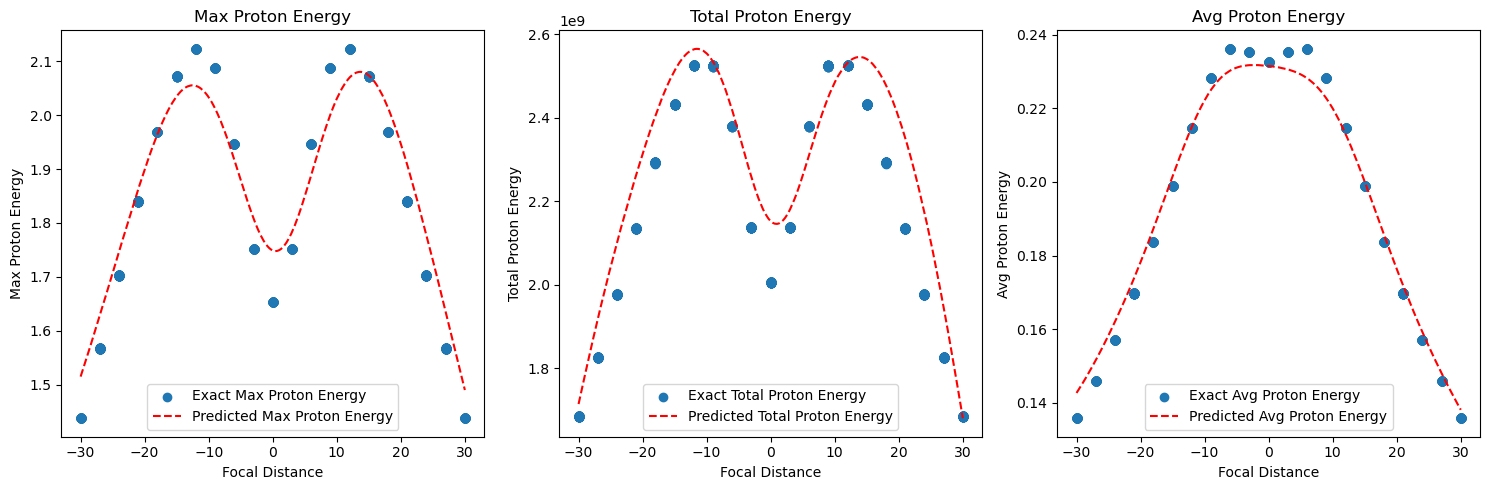

In [11]:
thickness = 0.5
intensity = 1e19
dx = 0.005
dI = 1e16
subset_df = train_df1[(train_df1["Target Thickness"]>thickness-dx) & (train_df1["Target Thickness"] < thickness+dx) & (train_df1["Intensity"]<intensity+dI) & (train_df1["Intensity"] > intensity-dI)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
print(subset_df.shape)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs[0].scatter(subset_df["Focal Distance"], subset_df["Max Exact Energy"], label="Exact Max Proton Energy")
axs[0].plot(focus_dip, max_dip, 'r--',label="Predicted Max Proton Energy")
axs[0].set_xlabel("Focal Distance")
axs[0].set_ylabel("Max Proton Energy")
axs[0].set_title("Max Proton Energy")
axs[1].scatter(subset_df["Focal Distance"], subset_df["Total Exact Energy"], label="Exact Total Proton Energy")
axs[1].plot(focus_dip, tot_dip, 'r--',label="Predicted Total Proton Energy")
axs[1].set_xlabel("Focal Distance")
axs[1].set_ylabel("Total Proton Energy")
axs[1].set_title("Total Proton Energy")
axs[2].scatter(subset_df["Focal Distance"], subset_df["Avg Exact Energy"], label="Exact Avg Proton Energy")
axs[2].plot(focus_dip, avg_dip, 'r--',label="Predicted Avg Proton Energy")
axs[2].set_xlabel("Focal Distance")
axs[2].set_ylabel("Avg Proton Energy")
axs[2].set_title("Avg Proton Energy")
#ax.scatter(subset_df["Focal Distance"], subset_df["Max Proton Energy"], s=5, label="Noisy Max Proton Energy", marker='x')
axs[0].legend(loc='lower center')
axs[1].legend(loc='lower center')
axs[2].legend(loc='lower center')
fig.tight_layout()

### Generate + Save DataFrame of 3 Characteristic Energies Across Input Space

In [12]:
def generate_random_points(bounds, n, seed):
    np.random.seed(seed)
    points = []
    for bound in bounds:
        points.append(np.random.uniform(bound[0], bound[1], n))
    return np.array(points).transpose()

random_seed = 0
bounds = [(1e19, 1e19), (0.5, 5.0), (-20.0, 20.0), (1e-7, 1e-7)] # Intensity, Thickness, Focus, Contrast.  Intensity and Contrast are fixed at 1e19 and 1e-7, respectively, to explore 2D slice of parameter space.
n_points = 100000
random_points = generate_random_points(bounds, n_points, random_seed)
random_points_scaled = input_transformer.transform(random_points).astype(datype)
random_preds = output_transformer.inverse_transform(model.predict(random_points_scaled))
random_max = random_preds[:, 0]
random_tot = random_preds[:, 1]
random_avg = random_preds[:, 2]
batch_df = pd.DataFrame({"Intensity": random_points[:, 0], "Target Thickness": random_points[:, 1], "Focal Distance": random_points[:, 2], "Contrast": random_points[:, 3], "E Max": random_max, "E Tot": random_tot, "E Avg": random_avg})
batch_df.head(25)

,Intensity,Target Thickness,Focal Distance,Contrast,E Max,E Tot,E Avg
0,1.000000e+19,2.908657,-11.289205,1.000000e-07,1.276978,1.299455e+09,0.172975
1,1.000000e+19,4.568199,3.489989,1.000000e-07,0.890401,8.788742e+08,0.154611
2,1.000000e+19,2.760785,19.504532,1.000000e-07,1.158180,1.047029e+09,0.141504
3,1.000000e+19,0.953915,18.034682,1.000000e-07,1.809687,2.127157e+09,0.178586
4,1.000000e+19,2.874119,-6.281141,1.000000e-07,1.215059,1.277828e+09,0.180472
5,1.000000e+19,3.700530,-4.244270,1.000000e-07,1.026536,1.045827e+09,0.168424
6,1.000000e+19,1.908294,3.429251,1.000000e-07,1.365545,1.458944e+09,0.197338
7,1.000000e+19,0.726464,-7.446362,1.000000e-07,1.884949,2.311695e+09,0.224299
8,1.000000e+19,1.054769,14.129452,1.000000e-07,1.842299,2.155333e+09,0.194902
9,1.000000e+19,4.008608,1.212541,1.000000e-07,0.944284,9.492173e+08,0.161807


In [13]:
import os
directory = 'predictions_dfs'
if not os.path.exists(directory):
    os.makedirs(directory)
batch_df.to_csv(f'predictions_dfs/svgp_{n_points}_noise_{noise_level}.csv', index=False)